# [IAPR][iapr]: Project ‒  Coin classification


**Group ID:** 56

**Author 1 (sciper):** Shujiro Shobayashi (314853)  
**Author 2 (sciper):** Camille Pittet (326866)   
**Author 3 (sciper):** Renuka Singh Virk (326470) 

**Release date:** 26.04.2024  
**Due date:** 31.05.2024 (8:15 pm)


## Important notes

Each group must upload an archive by May 29th, 11:59 PM that includes:

1. A report of your work in Jupyter Notebook format. It should provide detailed explanations of your method along with the code for every step of the project. The Jupyter Notebook should be capable of generating the final submission you submitted on Kaggle when rerun.
2. A requirements.txt file listing all Python packages you used.
3. Any additional files that you used.
TAs should be able to rerun your code end to end without having any issues. If not, you might lose part of the points during grading.

Please name the archive file with the number of your team, e.g. Group28.zip.

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from skimage.color import rgb2gray
from typing import Callable
from datetime import datetime
from helper_functions import *
from skimage.morphology import *

In [2]:
# PLOTTING FUNCTION TO ADD TO HELPER FUNCTIONS

def plot_chf_and_euro(img_chf, img_eur, chf_title, eur_title, color_map):

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    ax[0].imshow(img_chf, cmap = color_map)
    ax[0].set_title(chf_title)  # Set title for the first image
    ax[1].imshow(img_eur, cmap =  color_map)
    ax[1].set_title(eur_title)  # Set title for the second image

    # Remove the axis ticks
    ax[0].axis('off')
    ax[1].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()


## Data Inspection

### Reference Coins

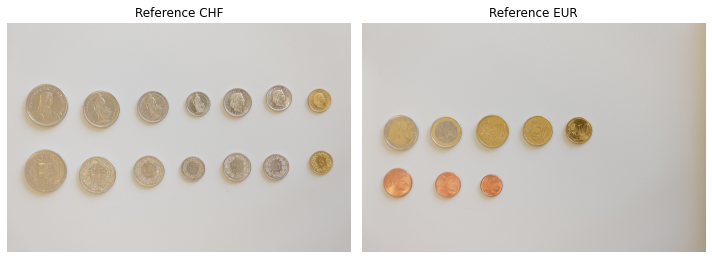

In [3]:
# Define paths
path_chf = './data/ref/ref_chf.JPG'
path_eur = './data/ref/ref_eur.JPG'

# Load images
img_ref_chf = np.array(Image.open(path_chf))
img_ref_eur = np.array(Image.open(path_eur))

plot_chf_and_euro(img_ref_chf, img_ref_eur, 'Reference CHF', 'Reference EUR' , 'viridis')

### Load Data

In [4]:
# load data
sample_submission = pd.read_csv("data/sample_submission.csv")
train_labels = pd.read_csv("data/train_labels.csv")

# display data 
display(sample_submission.head())
display(train_labels.head())

id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0  L0000000     0     0     0       0       0       0        0     0     0   
1  L0000001     0     0     0       0       0       0        0     0     0   
2  L0000002     0     0     0       0       0       0        0     0     0   
3  L0000003     0     0     0       0       0       0        0     0     0   
4  L0000004     0     0     0       0       0       0        0     0     0   

   0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01EUR  OOD  
0       0       0       0        0        0        0    0  
1       0       0       0        0        0        0    0  
2       0       0       0        0        0        0    0  
3       0       0       0        0        0        0    0  
4       0       0       0        0        0        0    0

id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0  L1010281     0     0     0       0       2       3        1     0     0   
1  L1010298     0     2     1       2       0       0        0     0     0   
2  L1010321     0     0     1       2       0       0        0     1     2   
3  L1010310     0     0     1       1       0       0        1     2     0   
4  L1010300     0     1     0       0       0       0        0     1     0   

   0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01EUR  OOD  
0       0       0       0        2        0        0    0  
1       0       0       0        0        0        0    0  
2       0       2       1        0        0        0    0  
3       1       0       0        0        1        0    0  
4       2       0       1        0        0        0    0

## Image Processing

### Convert to Grayscale

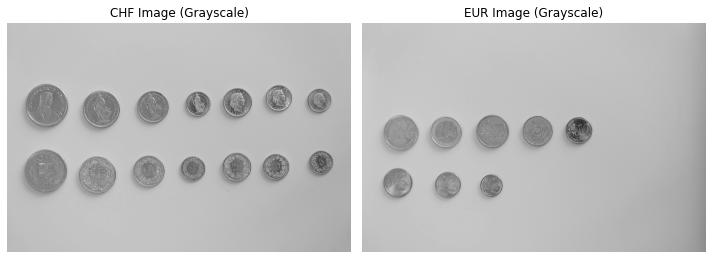

In [5]:
# Convert images to grayscale
chf_gray = rgb2gray(img_ref_chf)
eur_gray = rgb2gray(img_ref_eur)

plot_chf_and_euro(chf_gray, eur_gray, 'CHF Image (Grayscale)', 'EUR Image (Grayscale)' , 'gray')


## Rescale the intensities to facilitate threshold selection

0.23038705882352944
1.0


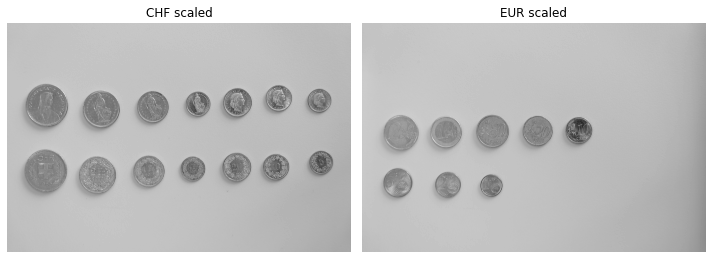

In [6]:
# Rescale the pixel values to the range 0 to 255
chf_scaled = ((chf_gray - 0.23) / 0.77) * 255 # change those values
eur_scaled = ((eur_gray - 0.23) / 0.77) * 255

print(np.min(chf_gray))
print(np.max(chf_gray))

plot_chf_and_euro(chf_scaled, eur_scaled, 'CHF scaled', 'EUR scaled', 'gray')


### Find appropriate hsv Thresholds

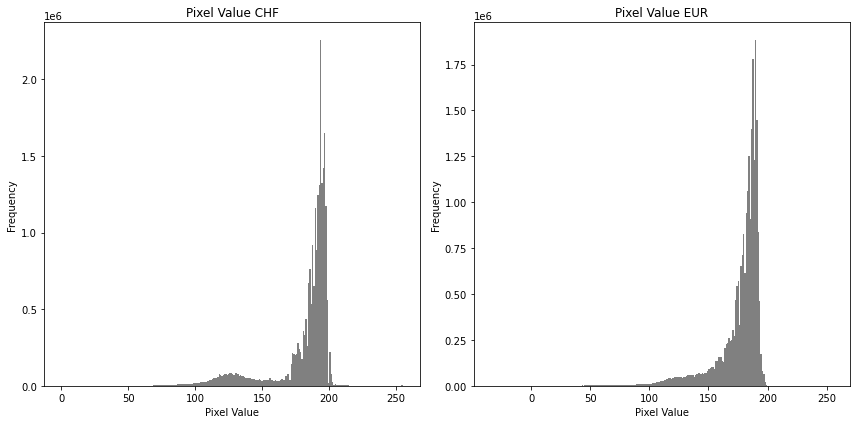

In [7]:

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram of CHF pixel values
axs[0].hist(chf_scaled.ravel(), bins=256, range=(np.min(chf_scaled), np.max(chf_scaled)), color='gray', edgecolor='none')
axs[0].set_title('Pixel Value CHF')
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

# Plot histogram of EUR pixel values
axs[1].hist(eur_scaled.ravel(), bins=256, range=(np.min(eur_scaled), np.max(eur_scaled)), color='gray', edgecolor='none')
axs[1].set_title('Pixel Value EUR')
axs[1].set_xlabel('Pixel Value')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Threshold Image

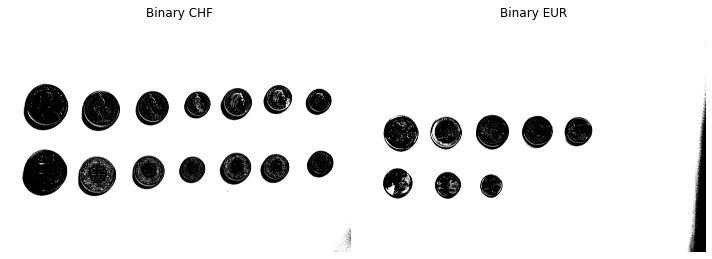

The array contains only boolean values.


In [8]:
chf_threshold = chf_scaled > 165 # avant 150
eur_threshold = eur_scaled > 145

# Binary
#chf_threshold[chf_threshold < 150] = 256 

plot_chf_and_euro(chf_threshold, eur_threshold, "Binary CHF", 'Binary EUR', 'gray')

# Check if all elements in the array are either True or False
if np.all(np.logical_or(chf_threshold == True, chf_threshold == False)):
    print("The array contains only boolean values.")
else:
    print("The array contains non-boolean values.")


## Morphology

### Closing

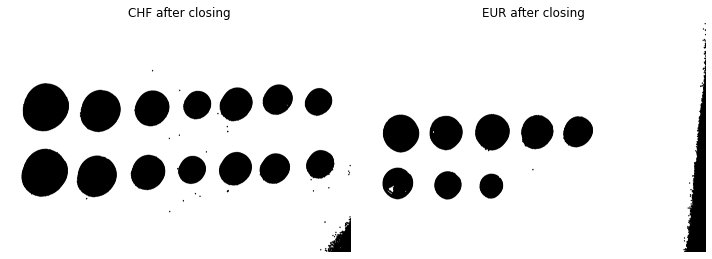

In [14]:
#chf_closed = binary_closing(chf_threshold, disk(50))
eur_closed = binary_erosion(eur_threshold, disk(12))

chf_closed = binary_erosion(chf_threshold, disk (12))
#chf_closed = binary_dilation(chf_closed, disk(5))
# chf_closed = remove_holes(chf_closed, 15)

plot_chf_and_euro(chf_closed, eur_closed, 'CHF after closing', 'EUR after closing', 'gray')

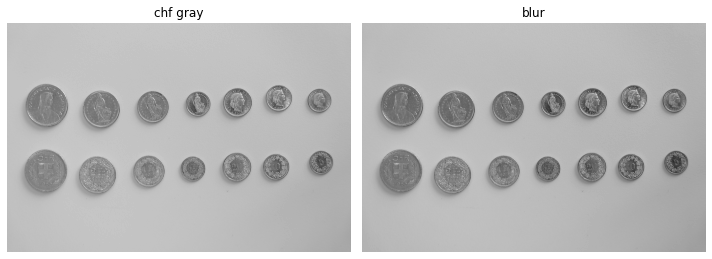

In [16]:
# Trying edge detection

# Apply Gaussian blurring to reduce noise
gray_blur = cv2.GaussianBlur(chf_gray, (5, 5), 0)

plot_chf_and_euro(chf_gray, gray_blur, 'chf gray', 'blur', 'gray')


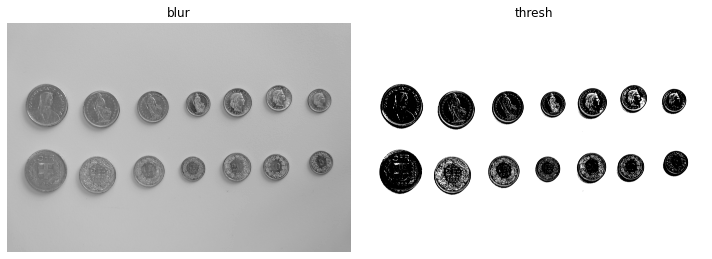

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [21]:
# Threshold the image
#thresh = chf_scaled > 150 
thresh = np.where(chf_scaled > 150, 256, 0)

plot_chf_and_euro(gray_blur, thresh, 'blur', 'thresh', 'gray')


In [22]:
#Find contours
thresh = thresh.astype(np.uint8)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [23]:
# THIS ONE TAKES AT LEAST 56 MINUTES TO RUN , either a prob with my ocmpu
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(chf_gray, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow('Detected Coins', chf_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Trying simple method (renuka)

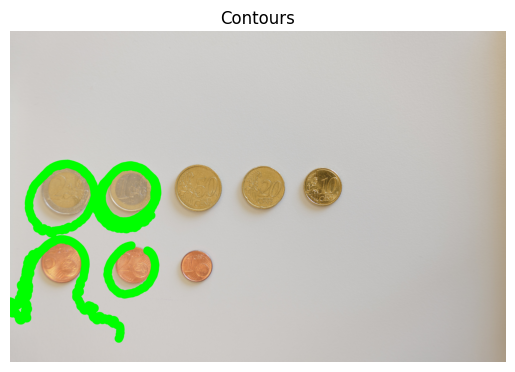

In [17]:
image = cv2.imread('./data/ref/ref_eur.JPG')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_blur = cv2.GaussianBlur(image, (71, 71), 0)
image_blur = cv2.cvtColor(image_blur, cv2.COLOR_BGR2GRAY)
image_equalized = cv2.equalizeHist(image_blur)
image_canny = cv2.Canny(image_equalized, 0, 180)  # Adjust Canny thresholds

contours, hierarchy = cv2.findContours(image_canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours
cv2.drawContours(image, contours, -1, (0, 255, 0), 100)  # Adjust contour color and thickness
#print(contours)
# Display the image with contours
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()


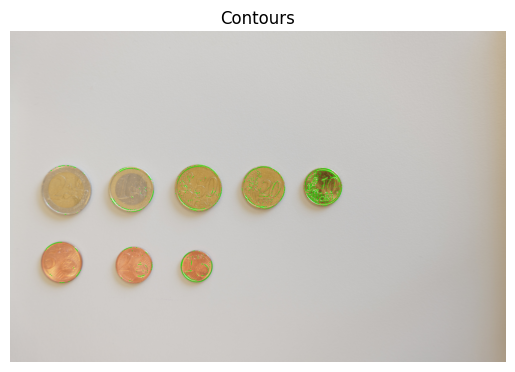

In [18]:
# Read the image
image = cv2.imread('./data/ref/ref_eur.JPG')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (15, 15), 0)

# Use adaptive thresholding to segment coins
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

# Perform morphological operations to clean up the image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours
contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original image
result = image.copy()
cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()


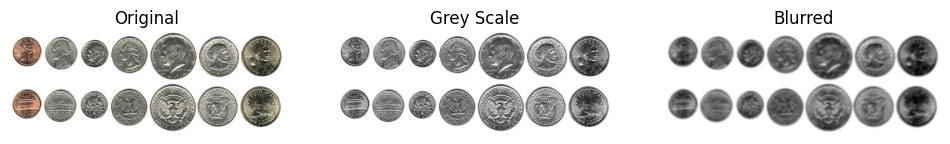

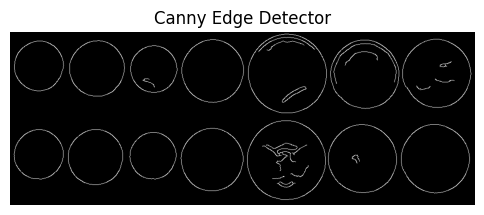

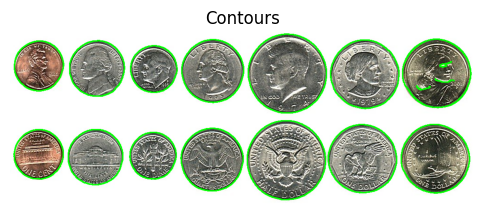

In [6]:
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread("money.jpg")

# Convert to grayscale
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grey, (17, 17), 0)

# Display original, grayscale, and blurred images as subplots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grey, cmap='gray')
plt.title('Grey Scale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.show()

# Canny edge detector
outline = cv2.Canny(blurred, 30, 150)

# Display Canny edge detector result
plt.figure(figsize=(6, 6))
plt.imshow(outline, cmap='gray')
plt.title('Canny Edge Detector')
plt.axis('off')
plt.show()

# Find contours
(cnts, _) = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
result = img.copy()
cv2.drawContours(result, cnts, -1, (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()


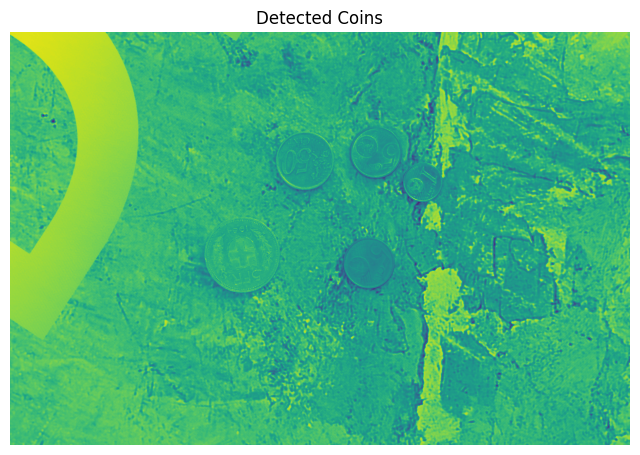

In [45]:
img = cv2.imread('./data/train/2. noisy_bg/L1010325.JPG')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
opening = apply_opening(gray, 5)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
contours, _ = cv2.findContours(unknown, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
result = img.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 10)  # Increased thickness to 5

# Convert image from BGR to RGB for Matplotlib
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(opening)
plt.title('Detected Coins')
plt.axis('off')
plt.show()

In [82]:
def find_contour(img, plot=False):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    _, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    contours, _ = cv2.findContours(unknown, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    result = img.copy()
    cv2.drawContours(result, contours, -1, (255, 0, 0), 10)  # Increased thickness to 5

    # Convert image from BGR to RGB for Matplotlib
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    if plot==True:
        # Display the result
        plt.figure(figsize=(8, 6))
        plt.imshow(result_rgb)
        plt.title('Detected Coins')
        plt.axis('off')
        plt.show()
        

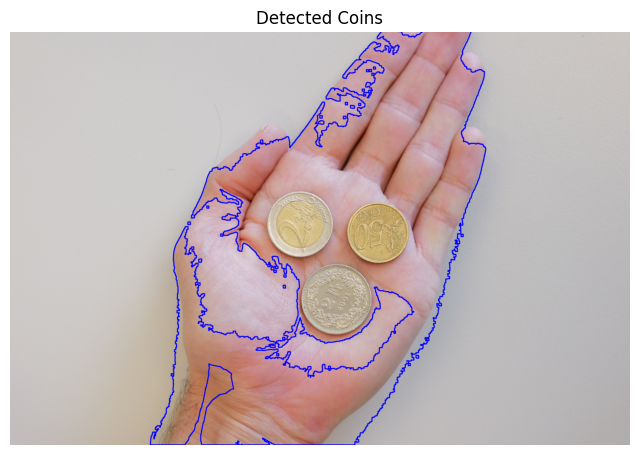

In [83]:
image_hand = cv2.imread('./data/train/3. hand/L1010373.JPG')
find_contour(image_hand, plot=True)


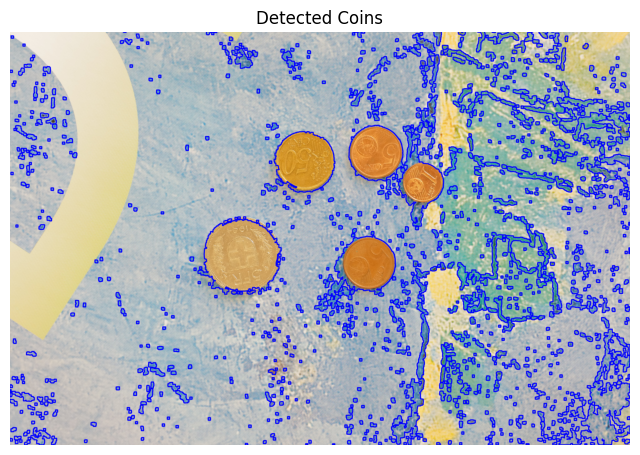

In [84]:
image_noisy = cv2.imread('./data/train/2. noisy_bg/L1010325.JPG')
find_contour(image_noisy, plot=True)


# TRYING FROM LAB 1 OPENING

In [185]:
img = cv2.imread('./data/train/2. noisy_bg/L1010325.JPG')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel_open = np.ones((3,3),np.uint8)
#blurred_img2 = cv2.blur(thresh, (100, 100))
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel_open, iterations = 4)
kernel_close = np.ones((40,40),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
kernel_open2 = np.ones((30,30),np.uint8)
opening2 = cv2.morphologyEx(closing,cv2.MORPH_OPEN, kernel_open2, iterations = 4)
kernel_close2 = np.ones((100,100),np.uint8)
closing2 = cv2.morphologyEx(opening2, cv2.MORPH_CLOSE, kernel_close2)
kernel_open3 = np.ones((20,20),np.uint8)
opening3 = cv2.morphologyEx(closing2,cv2.MORPH_OPEN, kernel_open3, iterations = 4)

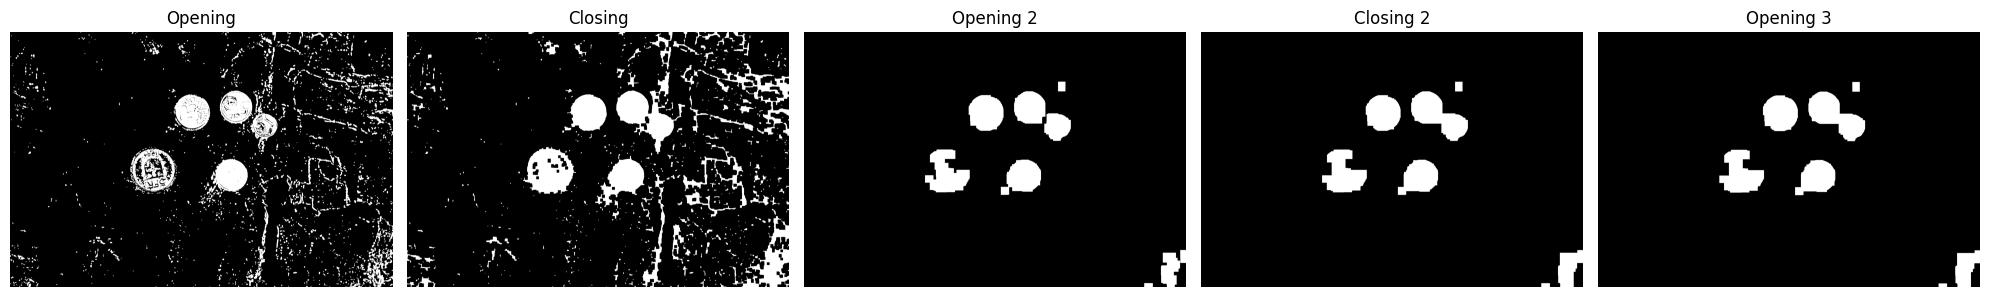

In [186]:

# Create a figure and subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Increased figure width for better visualization

# Plot 'opening'
axs[0].imshow(opening, cmap='gray')
axs[0].set_title('Opening')
axs[0].axis('off')

# Plot 'closing'
axs[1].imshow(closing, cmap='gray')
axs[1].set_title('Closing')
axs[1].axis('off')

# Plot 'opening2'
axs[2].imshow(opening2, cmap='gray') 
axs[2].set_title('Opening 2')
axs[2].axis('off')

# Plot 'closing2'
axs[3].imshow(closing2, cmap='gray')
axs[3].set_title('Closing 2')
axs[3].axis('off')

# Plot 'opening3'
axs[4].imshow(opening3, cmap='gray') 
axs[4].set_title('Opening 3')
axs[4].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


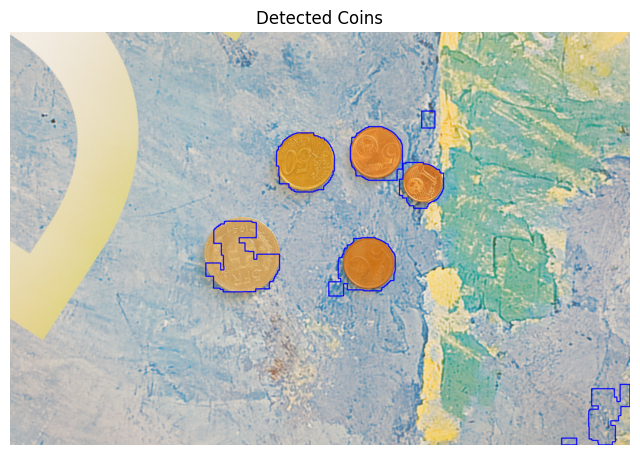

In [187]:
sure_bg = cv2.dilate(opening2,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
contours, _ = cv2.findContours(unknown, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
result = img.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 10)  # Increased thickness to 5

# Convert image from BGR to RGB for Matplotlib
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(result_rgb)
plt.title('Detected Coins')
plt.axis('off')
plt.show()

# LATEST VERSION: works for neutral and noisy bg

In [190]:
def find_contour(img, plot=False):
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # perfom opening and closing to remove background
    kernel_open = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel_open, iterations = 4)
    kernel_close = np.ones((40,40),np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
    kernel_open2 = np.ones((30,30),np.uint8)
    opening2 = cv2.morphologyEx(closing,cv2.MORPH_OPEN, kernel_open2, iterations = 4)

    # sure background area
    kernel = np.ones((5,5),np.uint8)
    sure_bg = cv2.dilate(opening2, kernel ,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    _, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    contours, _ = cv2.findContours(unknown, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    result = img.copy()
    cv2.drawContours(result, contours, -1, (255, 0, 0), 10)  # Increased thickness to 5
    # Convert image from BGR to RGB for Matplotlib
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    if plot==True:
        # Display the result
        plt.figure(figsize=(8, 6))
        plt.imshow(result_rgb)
        plt.title('Detected Coins')
        plt.axis('off')
        plt.show()
        

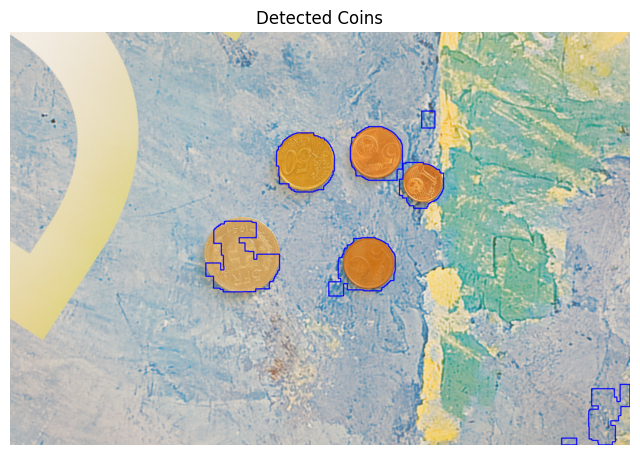

In [191]:
image_noisy = cv2.imread('./data/train/2. noisy_bg/L1010325.JPG')
find_contour(image_noisy, plot=True)


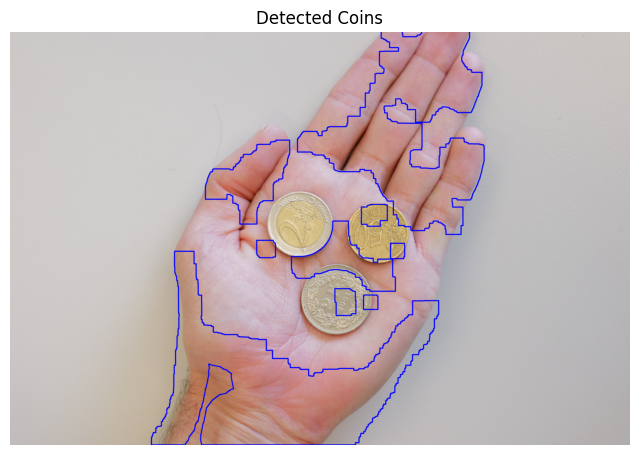

In [192]:
image_hand = cv2.imread('./data/train/3. hand/L1010373.JPG')
find_contour(image_hand, plot=True)


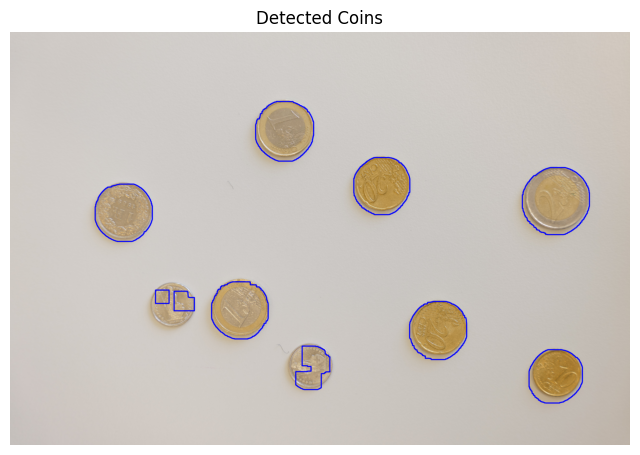

In [195]:
image_neutral = cv2.imread('./data/train/1. neutral_bg/L1010321.JPG')
find_contour(image_neutral, plot=True)


# HAND detection

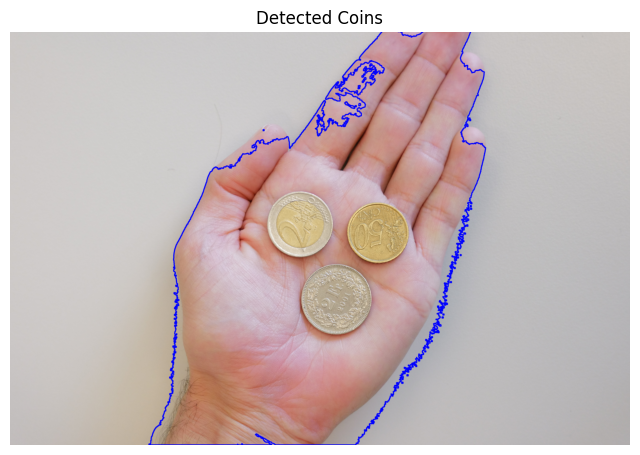

In [258]:
gray = cv2.cvtColor(image_hand,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
contours, _ = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
result = image_hand.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 10)  # Increased thickness to 5

# Convert image from BGR to RGB for Matplotlib
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(result_rgb)
plt.title('Detected Coins')
plt.axis('off')
plt.show()

In [267]:
def create_hand_mask(image, contours):
    # Create a blank mask of the same size as the input image
    mask = np.zeros_like(image, dtype=np.uint8)

    # Draw filled contours of the hand on the mask
    cv2.drawContours(mask, contours, -1, (255), cv2.FILLED)

    # Convert the mask to binary (0s and 255s)
    hand_mask = np.where(mask > 0, 255, 0).astype(np.uint8)

    return hand_mask

# Usage:
hand_mask = create_hand_mask(image_hand, contours)

In [ ]:
hand_region = cv2.bitwise_and(image_hand, image_hand, mask=hand_mask)